# 프로젝트 : ResNet Ablation Study

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Input Normalization

In [3]:
def normalize_and_resize_img(image,label):
    image=tf.image.resize(image,[224,224])
    return tf.cast(image, tf.float32)/255., label

In [4]:
def apply_normalize_on_dataset(ds,is_test=False, batch_size=16):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=1)
    ds = ds.batch(batch_size)
    if not is_test:
        ds=ds.repeat()
        ds=ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 블록구성

In [6]:
# 추가로 import해야 할 패키지들을 먼저 가져옵니다. 
from tensorflow.python.keras import backend
from tensorflow.python.keras import regularizers
from tensorflow.python.keras import initializers
from tensorflow.python.keras import models
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers
from tensorflow.python.keras.applications import imagenet_utils

# block 안에 반복적으로 활용되는 L2 regularizer를 선언해 줍니다.
def _gen_l2_regularizer(use_l2_regularizer=True, l2_weight_decay=1e-4):
  return regularizers.l2(l2_weight_decay) if use_l2_regularizer else None

In [7]:
def conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2),
               use_l2_regularizer=True,
               batch_norm_decay=0.9,
               batch_norm_epsilon=1e-5):
  """A block that has a conv layer at shortcut.
  Note that from stage 3,
  the second conv layer at main path is with strides=(2, 2)
  And the shortcut should have strides=(2, 2) as well
  Args:
    input_tensor: input tensor
    kernel_size: default 3, the kernel size of middle conv layer at main path
    filters: list of integers, the filters of 3 conv layer at main path
    stage: integer, current stage label, used for generating layer names
    block: 'a','b'..., current block label, used for generating layer names
    strides: Strides for the second conv layer in the block.
    use_l2_regularizer: whether to use L2 regularizer on Conv layer.
    batch_norm_decay: Moment of batch norm layers.
    batch_norm_epsilon: Epsilon of batch borm layers.
  Returns:
    Output tensor for the block.
  """
  filters1, filters2, filters3 = filters
  if backend.image_data_format() == 'channels_last':
    bn_axis = 3
  else:
    bn_axis = 1
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  x = layers.Conv2D(
      filters1, (1, 1),
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '2a')(
          input_tensor)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name=bn_name_base + '2a')(
          x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(
      filters2,
      kernel_size,
      strides=strides,
      padding='same',
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '2b')(
          x)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name=bn_name_base + '2b')(
          x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(
      filters3, (1, 1),
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '2c')(
          x)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name=bn_name_base + '2c')(
          x)

  shortcut = layers.Conv2D(
      filters3, (1, 1),
      strides=strides,
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '1')(
          input_tensor)
  shortcut = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name=bn_name_base + '1')(
          shortcut)

  x = layers.add([x, shortcut])
  x = layers.Activation('relu')(x)
  return x


In [8]:
def identity_block(input_tensor,
                   kernel_size,
                   filters,
                   stage,
                   block,
                   use_l2_regularizer=True,
                   batch_norm_decay=0.9,
                   batch_norm_epsilon=1e-5):
  """The identity block is the block that has no conv layer at shortcut.
  Args:
    input_tensor: input tensor
    kernel_size: default 3, the kernel size of middle conv layer at main path
    filters: list of integers, the filters of 3 conv layer at main path
    stage: integer, current stage label, used for generating layer names
    block: 'a','b'..., current block label, used for generating layer names
    use_l2_regularizer: whether to use L2 regularizer on Conv layer.
    batch_norm_decay: Moment of batch norm layers.
    batch_norm_epsilon: Epsilon of batch borm layers.
  Returns:
    Output tensor for the block.
  """
  filters1, filters2, filters3 = filters
  if backend.image_data_format() == 'channels_last':
    bn_axis = 3
  else:
    bn_axis = 1
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  x = layers.Conv2D(
      filters1, (1, 1),
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '2a')(
          input_tensor)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name=bn_name_base + '2a')(
          x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(
      filters2,
      kernel_size,
      padding='same',
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '2b')(
          x)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name=bn_name_base + '2b')(
          x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(
      filters3, (1, 1),
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '2c')(
          x)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name=bn_name_base + '2c')(
          x)

  x = layers.add([x, input_tensor])
  x = layers.Activation('relu')(x)
  return x

In [9]:
def resnet50(num_classes,
             batch_size=None,
             use_l2_regularizer=True,
             rescale_inputs=False,
             batch_norm_decay=0.9,
             batch_norm_epsilon=1e-5):
  """Instantiates the ResNet50 architecture.
  Args:
    num_classes: `int` number of classes for image classification.
    batch_size: Size of the batches for each step.
    use_l2_regularizer: whether to use L2 regularizer on Conv/Dense layer.
    rescale_inputs: whether to rescale inputs from 0 to 1.
    batch_norm_decay: Moment of batch norm layers.
    batch_norm_epsilon: Epsilon of batch borm layers.
  Returns:
      A Keras model instance.
  """

  input_shape = (32, 32, 3)  # CIFAR100을 위한 input_shape 조정입니다. 
  img_input = layers.Input(shape=input_shape, batch_size=batch_size)
  if rescale_inputs:
    # Hub image modules expect inputs in the range [0, 1]. This rescales these
    # inputs to the range expected by the trained model.
    x = layers.Lambda(
        lambda x: x * 255.0 - backend.constant(
            imagenet_preprocessing.CHANNEL_MEANS,
            shape=[1, 1, 3],
            dtype=x.dtype),
        name='rescale')(
            img_input)
  else:
    x = img_input

  if backend.image_data_format() == 'channels_first':
    x = layers.Permute((3, 1, 2))(x)
    bn_axis = 1
  else:  # channels_last
    bn_axis = 3

  block_config = dict(
      use_l2_regularizer=use_l2_regularizer,
      batch_norm_decay=batch_norm_decay,
      batch_norm_epsilon=batch_norm_epsilon)
  x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(x)
  x = layers.Conv2D(
      64, (7, 7),
      strides=(2, 2),
      padding='valid',
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name='conv1')(
          x)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name='bn_conv1')(
          x)
  x = layers.Activation('relu')(x)
  x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

  x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1), **block_config)
  x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', **block_config)
  x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', **block_config)

  x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', **block_config)
  x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', **block_config)
  x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', **block_config)
  x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', **block_config)

  x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', **block_config)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b', **block_config)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c', **block_config)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d', **block_config)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e', **block_config)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f', **block_config)

  x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a', **block_config)
  x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', **block_config)
  x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', **block_config)

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(
      num_classes,
      kernel_initializer=initializers.RandomNormal(stddev=0.01),
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      bias_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name='fc1000')(
          x)

  # A softmax that is followed by the model loss must be done cannot be done
  # in float16 due to numeric issues. So we pass dtype=float32.
  x = layers.Activation('softmax', dtype='float32')(x)

  # Create model.
  return models.Model(img_input, x, name='resnet50')

In [10]:
model = resnet50(num_classes=10)

model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9408        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [11]:
def conv_block2(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2),
               use_l2_regularizer=True,
               batch_norm_decay=0.9,
               batch_norm_epsilon=1e-5):
  """A block that has a conv layer at shortcut.
  Note that from stage 3,
  the second conv layer at main path is with strides=(2, 2)
  And the shortcut should have strides=(2, 2) as well
  Args:
    input_tensor: input tensor
    kernel_size: default 3, the kernel size of middle conv layer at main path
    filters: list of integers, the filters of 3 conv layer at main path
    stage: integer, current stage label, used for generating layer names
    block: 'a','b'..., current block label, used for generating layer names
    strides: Strides for the second conv layer in the block.
    use_l2_regularizer: whether to use L2 regularizer on Conv layer.
    batch_norm_decay: Moment of batch norm layers.
    batch_norm_epsilon: Epsilon of batch borm layers.
  Returns:
    Output tensor for the block.
  """
  filters1, filters2 = filters
  if backend.image_data_format() == 'channels_last':
    bn_axis = 3
  else:
    bn_axis = 1
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  x = layers.Conv2D(
      filters1, (1, 1),
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '2a')(
          input_tensor)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name=bn_name_base + '2a')(
          x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(
      filters2,
      kernel_size,
      strides=strides,
      padding='same',
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '2b')(
          x)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name=bn_name_base + '2b')(
          x)
  x = layers.Activation('relu')(x)

  
  shortcut = layers.Conv2D(
      filters2, (1, 1),
      strides=strides,
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '1')(
          input_tensor)
    
  shortcut = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name=bn_name_base + '1')(
          shortcut)

  x = layers.add([x, shortcut])
  x = layers.Activation('relu')(x)
  return x

In [12]:
def identity_block2(input_tensor,
                   kernel_size,
                   filters,
                   stage,
                   block,
                   use_l2_regularizer=True,
                   batch_norm_decay=0.9,
                   batch_norm_epsilon=1e-5):
  """The identity block is the block that has no conv layer at shortcut.
  Args:
    input_tensor: input tensor
    kernel_size: default 3, the kernel size of middle conv layer at main path
    filters: list of integers, the filters of 3 conv layer at main path
    stage: integer, current stage label, used for generating layer names
    block: 'a','b'..., current block label, used for generating layer names
    use_l2_regularizer: whether to use L2 regularizer on Conv layer.
    batch_norm_decay: Moment of batch norm layers.
    batch_norm_epsilon: Epsilon of batch borm layers.
  Returns:
    Output tensor for the block.
  """
  filters1, filters2 = filters
  if backend.image_data_format() == 'channels_last':
    bn_axis = 3
  else:
    bn_axis = 1
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  x = layers.Conv2D(
      filters1, (1, 1),
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '2a')(
          input_tensor)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name=bn_name_base + '2a')(
          x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(
      filters2,
      kernel_size,
      padding='same',
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '2b')(
          x)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name=bn_name_base + '2b')(
          x)

  x = layers.add([x, input_tensor])
  x = layers.Activation('relu')(x)
  return x

In [13]:
def resnet34(num_classes,
             batch_size=None,
             use_l2_regularizer=True,
             rescale_inputs=False,
             batch_norm_decay=0.9,
             batch_norm_epsilon=1e-5):
  """Instantiates the ResNet50 architecture.
  Args:
    num_classes: `int` number of classes for image classification.
    batch_size: Size of the batches for each step.
    use_l2_regularizer: whether to use L2 regularizer on Conv/Dense layer.
    rescale_inputs: whether to rescale inputs from 0 to 1.
    batch_norm_decay: Moment of batch norm layers.
    batch_norm_epsilon: Epsilon of batch borm layers.
  Returns:
      A Keras model instance.
  """

  input_shape = (32, 32, 3)  # CIFAR100을 위한 input_shape 조정입니다. 
  img_input = layers.Input(shape=input_shape, batch_size=batch_size)
  if rescale_inputs:
    # Hub image modules expect inputs in the range [0, 1]. This rescales these
    # inputs to the range expected by the trained model.
    x = layers.Lambda(
        lambda x: x * 255.0 - backend.constant(
            imagenet_preprocessing.CHANNEL_MEANS,
            shape=[1, 1, 3],
            dtype=x.dtype),
        name='rescale')(
            img_input)
  else:
    x = img_input

  if backend.image_data_format() == 'channels_first':
    x = layers.Permute((3, 1, 2))(x)
    bn_axis = 1
  else:  # channels_last
    bn_axis = 3

  block_config = dict(
      use_l2_regularizer=use_l2_regularizer,
      batch_norm_decay=batch_norm_decay,
      batch_norm_epsilon=batch_norm_epsilon)
  x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(x)
  x = layers.Conv2D(
      64, (7, 7),
      strides=(2, 2),
      padding='valid',
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name='conv1')(
          x)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name='bn_conv1')(
          x)
  x = layers.Activation('relu')(x)
  x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

  x = conv_block2(x, 3, [64, 64], stage=2, block='a', strides=(1, 1), **block_config)
  x = identity_block2(x, 3, [64, 64], stage=2, block='b', **block_config)
  x = identity_block2(x, 3, [64, 64], stage=2, block='c', **block_config)

  x = conv_block2(x, 3, [128, 128], stage=3, block='a', **block_config)
  x = identity_block2(x, 3, [128, 128], stage=3, block='b', **block_config)
  x = identity_block2(x, 3, [128, 128], stage=3, block='c', **block_config)
  x = identity_block2(x, 3, [128, 128], stage=3, block='d', **block_config)

  x = conv_block2(x, 3, [256, 256], stage=4, block='a', **block_config)
  x = identity_block2(x, 3, [256, 256], stage=4, block='b', **block_config)
  x = identity_block2(x, 3, [256, 256], stage=4, block='c', **block_config)
  x = identity_block2(x, 3, [256, 256], stage=4, block='d', **block_config)
  x = identity_block2(x, 3, [256, 256], stage=4, block='e', **block_config)
  x = identity_block2(x, 3, [256, 256], stage=4, block='f', **block_config)

  x = conv_block2(x, 3, [512, 512], stage=5, block='a', **block_config)
  x = identity_block2(x, 3, [512, 512], stage=5, block='b', **block_config)
  x = identity_block2(x, 3, [512, 512], stage=5, block='c', **block_config)

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(
      num_classes,
      kernel_initializer=initializers.RandomNormal(stddev=0.01),
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      bias_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name='fc1000')(
          x)

  # A softmax that is followed by the model loss must be done cannot be done
  # in float16 due to numeric issues. So we pass dtype=float32.
  x = layers.Activation('softmax', dtype='float32')(x)

  # Create model.
  return models.Model(img_input, x, name='resnet34')

In [14]:
model2 = resnet34(num_classes=10)

model2.summary()

Model: "resnet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9408        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

- 코드 예시와 비슷하게 나오지않아서 다른 코드를 참고하여 해보았다.

### ResNet block

In [15]:
def build_resnet_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=0,
                    is_50=False,
                    CHECK_CHANNEL=64,
                       plain=False,):

    flag = CHECK_CHANNEL == channel
    bn = 1
    # input layer
    x = input_layer
    
    # 들어오는 input을 init_identity에 저장시켜 놓는다.
    # 이전 블럭에서 들어오는 정보는 init_identity에서 저장
    init_identity=x

    if not is_50:
        # CNN 레이어
        # 블럭 내부 구성
        for cnn_num in range(num_cnn):
            
            # 블럭의 첫번째 conv층
            identity = x
            
            if flag :
                # 첫번째 Conv
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage{block_num+2}_{cnn_num+1}_conv1'
                )(x)    
                
            else :
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    strides=(2,2),
                    name=f'stage{block_num+2}_{cnn_num+1}_conv1'
                )(x)
                
            x = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(x)
            bn += 1
            x = keras.layers.Activation('relu')(x)
            
            # 두번째 conv 층 (블럭의 conv 마지막 레이어)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'stage{block_num+2}_{cnn_num+1}_conv2'
            )(x)
            x = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(x)
            bn += 1
            x = keras.layers.Activation('relu')(x)
            
            
            # plain을 True로 주면 아래 shortcut connection을 생략
            if not plain :
                
                # identity block
                if flag :
                    init_identity = keras.layers.Conv2D(
                        filters=channel,
                        kernel_size=(1,1),
                        kernel_initializer='he_normal',
                        padding='same',
                        name=f'stage{block_num+2}_{cnn_num+1}_short'
                    )(init_identity)

                else :
                    init_identity = keras.layers.Conv2D(
                        filters=channel,
                        kernel_size=(1,1),
                        kernel_initializer='he_normal',
                        padding='same',
                        strides=(2,2),
                        name=f'stage{block_num+2}_{cnn_num+1}_short'
                    )(init_identity)

                init_identity = keras.layers.BatchNormalization(
                        name=f'stage{block_num+2}_{cnn_num+1}_bn4'
                )(init_identity)

                flag=True

                # AD
                if cnn_num == 0:
                    x = keras.layers.Add(
                        name=f'stage{block_num+2}_{cnn_num+1}_add'
                    )([x, init_identity])
                    x = keras.layers.Activation('relu')(x)
                else :
                    x = keras.layers.Add(
                        name=f'stage{block_num+2}_{cnn_num+1}_add'
                    )([x, identity])
                    x = keras.layers.Activation('relu')(x)

    # is_50 = False
    else:

        for cnn_num in range(num_cnn):
            
            # 블럭의 첫번째 conv층 쌓기
            identity = x
            
            if flag :
                 x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage{block_num+2}_{cnn_num+1}_conv1'
                )(x)    
                
            else :
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    kernel_initializer='he_normal',
                    padding='same',
                    strides=(2,2),
                    name=f'stage{block_num+2}_{cnn_num+1}_conv1'
                )(x)
                

            x = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(x)
            bn+=1
            x = keras.layers.Activation('relu')(x)
            
            ######
            # 두번째 conv 층 (블럭의 conv 마지막 레이어)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'stage{block_num+2}_{cnn_num+1}_conv2',
            )(x)
            x = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(x)
            bn+=1
            x = keras.layers.Activation('relu')(x)
            
            ### 3번째 Conv (앞에 채널의 4배)
            x = keras.layers.Conv2D(
                filters=channel*4,
                kernel_size=(1,1),
                kernel_initializer='he_normal',
                padding='same',
                name=f'stage{block_num+2}_{cnn_num+1}_conv3'
            )(x)
            x = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(x)
            bn+=1
            x = keras.layers.Activation('relu')(x)
            
            
            # identity block
            
            if not plain :
                
                if flag :
                    init_identity = keras.layers.Conv2D(
                        filters=channel*4,
                        kernel_size=(1,1),
                        kernel_initializer='he_normal',
                        padding='same',
                        name=f'stage{block_num+2}_{cnn_num+1}_short'
                    )(init_identity)

                else :
                    init_identity = keras.layers.Conv2D(
                        filters=channel*4,
                        kernel_size=(1,1),
                        kernel_initializer='he_normal',
                        padding='same',
                        strides=(2,2),
                        name=f'stage{block_num+2}_{cnn_num+1}_short'
                    )(init_identity)

                init_identity = keras.layers.BatchNormalization(
                    name=f'stage{block_num+2}_{cnn_num+1}_bn4'
                )(init_identity)

                flag=True



                # shortcut connection에서는 블럭 내에서 생기는 identity를 사용
                if cnn_num == 0:
                    x = keras.layers.Add(
                        name=f'stage{block_num+2}_{cnn_num+1}_add'
                    )([x, init_identity])
                    x = keras.layers.Activation('relu')(x)
                else :
                    x = keras.layers.Add(
                        name=f'stage{block_num+2}_{cnn_num+1}_add'
                    )([x, identity])
                    x = keras.layers.Activation('relu')(x)

    return x, CHECK_CHANNEL

### ResNet34

In [16]:
def build_resnet(input_shape=(32,32,3),
              num_cnn_list=[3, 4, 6, 3],
              channel_list=[64,128,256,512],
              num_classes=10,
                is_50=False,
                plain=False,):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape, name="input_layer")  # input layer를 만들어둡니다.
    output = input_layer # 뒤에서 사용하는 인자와 통일해주기 위해서 'output'이라고 한다
    
    output = keras.layers.Conv2D(
        filters=channel_list[0],
        kernel_size=(7,7),
        padding='same',
        strides=2,
        kernel_initializer='he_normal',
    )(output)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.MaxPooling2D(
        pool_size=(2,2), 
        strides=2,
        name='stage2_0_maxpooling'
    )(output)
    
    cc = 64
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output, cc = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i,
            is_50=is_50,
            CHECK_CHANNEL=cc,
            plain=plain
        )
        
    output = keras.layers.AveragePooling2D(pool_size=(1,1), name='avg_pool')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='sigmoid', name='fc1000')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [17]:
model_34 = build_resnet()

model_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation_88 (Activation)      (None, 16, 16, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

### ResNet-50

- (1X1 - 3X3 - 1X1 ) * 3
- (1X1 - 3X3 - 1X1 ) * 4
- (1X1 - 3X3 - 1X1 ) * 6
- (1X1 - 3X3 - 1X1 ) * 3

In [18]:
model_50 = build_resnet(num_cnn_list=[3, 4, 6, 3],
                        channel_list=[64,128,256,512],
                        is_50=True)

model_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   9472        input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_137 (Activation)     (None, 16, 16, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

### 데이터셋
- tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋

In [19]:
(ds_train, ds_valid), ds_info = tfds.load(
    'cats_vs_dogs',
    split=[
        'train[:80%]',
        'train[80%:]',
    ],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [20]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [21]:
ds_info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path='/aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0',
    download_size=786.68 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA tha

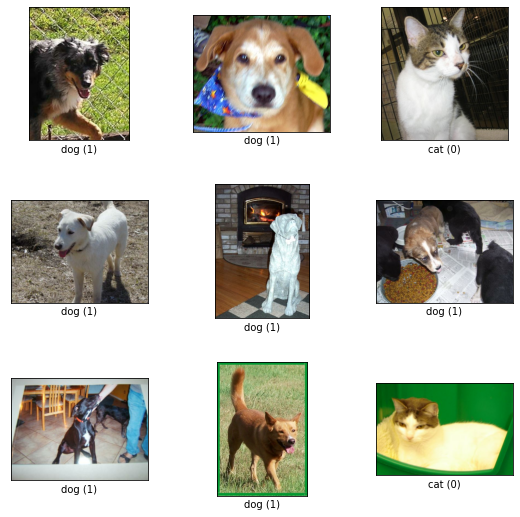

In [22]:
fig = tfds.show_examples(ds_train, ds_info)

### 데이터전처리
- 맨위에서 함수로 정의했지만 헷갈리므로 다시 정의

In [23]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [24]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [25]:
ds_train = apply_normalize_on_dataset(ds_train, is_test=False, batch_size=16)

In [26]:
ds_valid = apply_normalize_on_dataset(ds_valid, is_test=False, batch_size=16)

### Ablation Study

In [27]:
INPUT_SHAPE = (224, 224, 3)

In [28]:
# resnet-34
model_34 = build_resnet(input_shape=INPUT_SHAPE,
    num_cnn_list=[3, 4, 6, 3],
    channel_list=[64, 128, 256, 512],
    num_classes=1,
    is_50=False,
    plain=False,)

model_34.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 112, 112, 64) 9472        input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 112, 112, 64) 256         conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_202 (Activation)     (None, 112, 112, 64) 0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [29]:
# plain-34
plain_34 = build_resnet(input_shape=INPUT_SHAPE,
    num_cnn_list=[3, 4, 6, 3],
    channel_list=[64, 128, 256, 512],
    num_classes=1,
    is_50=False,
    plain=True,)

### ResNet-34 vs Plain-34

In [32]:
BATCH_SIZE = 16
EPOCH = 10
ds_train_len = 18610
ds_valid_len = 2326
ds_test_len = 2326

In [33]:
model_34.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001, clipnorm=1.),
                 metrics=['accuracy'])
    
res_history_34 = model_34.fit(
    ds_train,
    steps_per_epoch=int(ds_train_len/BATCH_SIZE),
    validation_steps=int(ds_test_len/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 356s 282ms/step - loss: 2.6219 - accuracy: 0.5148 - val_loss: 0.6704 - val_accuracy: 0.5793
Epoch 2/10
1163/1163 [==============================] - 307s 264ms/step - loss: 0.8562 - accuracy: 0.6081 - val_loss: 0.7198 - val_accuracy: 0.5466
Epoch 3/10
1163/1163 [==============================] - 313s 269ms/step - loss: 0.6678 - accuracy: 0.6427 - val_loss: 1.5859 - val_accuracy: 0.6248
Epoch 4/10
1163/1163 [==============================] - 307s 264ms/step - loss: 0.5871 - accuracy: 0.6921 - val_loss: 0.6756 - val_accuracy: 0.6870
Epoch 5/10
1163/1163 [==============================] - 307s 264ms/step - loss: 0.5635 - accuracy: 0.7157 - val_loss: 0.9175 - val_accuracy: 0.6740
Epoch 6/10
1163/1163 [==============================] - 311s 268ms/step - loss: 0.5405 - accuracy: 0.7299 - val_loss: 0.5870 - val_accuracy: 0.6832
Epoch 7/10
1163/1163 [==============================] - 308s 265ms/step - loss: 0.5073 - accuracy: 0.7519 - val_

In [34]:
plain_34.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001, clipnorm=1.),
                 metrics=['accuracy'])
    
pla_history_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_train_len/BATCH_SIZE),
    validation_steps=int(ds_test_len/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 270s 203ms/step - loss: 0.7732 - accuracy: 0.5090 - val_loss: 0.6987 - val_accuracy: 0.5116
Epoch 2/10
1163/1163 [==============================] - 211s 181ms/step - loss: 0.7099 - accuracy: 0.4984 - val_loss: 0.7298 - val_accuracy: 0.4914
Epoch 3/10
1163/1163 [==============================] - 222s 191ms/step - loss: 0.7084 - accuracy: 0.5090 - val_loss: 0.7212 - val_accuracy: 0.4793
Epoch 4/10
1163/1163 [==============================] - 214s 184ms/step - loss: 0.7054 - accuracy: 0.5041 - val_loss: 0.6891 - val_accuracy: 0.5397
Epoch 5/10
1163/1163 [==============================] - 210s 180ms/step - loss: 0.6982 - accuracy: 0.5196 - val_loss: 0.6915 - val_accuracy: 0.5185
Epoch 6/10
1163/1163 [==============================] - 210s 181ms/step - loss: 0.6986 - accuracy: 0.5105 - val_loss: 0.6968 - val_accuracy: 0.5345
Epoch 7/10
1163/1163 [==============================] - 210s 180ms/step - loss: 0.6979 - accuracy: 0.5171 - val_

### loss graph

In [35]:
def plot_loss_graph(res, pla, num) :
    plt.plot(res.history['loss'], 'r')
    plt.plot(pla.history['loss'], 'b')
    plt.title('Model training loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['res'+str(num), 'pla'+str(num)], loc='upper left')
    plt.show()

### acc graph

In [36]:
def plot_acc_graph(res, pla, num) :
    plt.plot(res.history['val_accuracy'], 'r')
    plt.plot(pla.history['val_accuracy'], 'b')
    plt.title('Model validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['res'+str(num), 'pla'+str(num)], loc='upper left')
    plt.show()

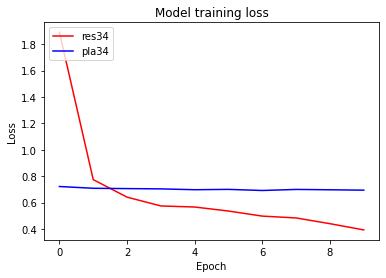

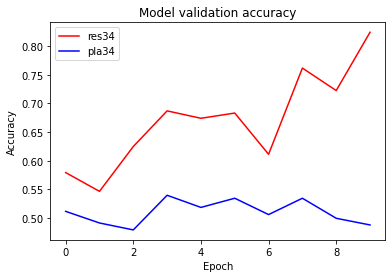

In [37]:
plot_loss_graph(res_history_34, pla_history_34, 34)
plot_acc_graph(res_history_34, pla_history_34, 34)

### ResNet-50 vs Plain-50

In [38]:
model_50 = build_resnet(input_shape=INPUT_SHAPE,
                        num_cnn_list=[3, 4, 6, 3],
                        channel_list=[64, 128, 256, 512],
                        num_classes=1,
                        is_50=True,
                        plain=False,)

In [39]:
plain_50 = build_resnet(input_shape=INPUT_SHAPE,
                        num_cnn_list=[3, 4, 6, 3],
                        channel_list=[64, 128, 256, 512],
                        num_classes=1,
                        is_50=True,
                        plain=True,)

In [40]:
model_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001, clipnorm=1.),
    metrics=['accuracy'],
)

res_history_50 = model_50.fit(
    ds_train,
    steps_per_epoch=int(ds_train_len/BATCH_SIZE),
    validation_steps=int(ds_test_len/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 569s 455ms/step - loss: 5.6504 - accuracy: 0.5359 - val_loss: 0.7308 - val_accuracy: 0.5073
Epoch 2/10
1163/1163 [==============================] - 503s 433ms/step - loss: 1.1567 - accuracy: 0.5541 - val_loss: 0.6658 - val_accuracy: 0.6017
Epoch 3/10
1163/1163 [==============================] - 503s 432ms/step - loss: 0.9542 - accuracy: 0.5822 - val_loss: 2.1828 - val_accuracy: 0.6259
Epoch 4/10
1163/1163 [==============================] - 503s 433ms/step - loss: 0.7319 - accuracy: 0.6518 - val_loss: 0.6679 - val_accuracy: 0.6444
Epoch 5/10
1163/1163 [==============================] - 503s 432ms/step - loss: 0.6353 - accuracy: 0.6803 - val_loss: 0.6039 - val_accuracy: 0.7129
Epoch 6/10
1163/1163 [==============================] - 508s 437ms/step - loss: 0.6428 - accuracy: 0.6977 - val_loss: 0.7098 - val_accuracy: 0.6983
Epoch 7/10
1163/1163 [==============================] - 512s 440ms/step - loss: 0.5895 - accuracy: 0.7192 - val_

In [41]:
plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001, clipnorm=1.),
    metrics=['accuracy']
)

pla_history_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_train_len/BATCH_SIZE),
    validation_steps=int(ds_test_len/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 343s 262ms/step - loss: 0.8461 - accuracy: 0.5037 - val_loss: 1.0532 - val_accuracy: 0.5186
Epoch 2/10
1163/1163 [==============================] - 269s 231ms/step - loss: 0.7472 - accuracy: 0.5031 - val_loss: 2.6282 - val_accuracy: 0.5095
Epoch 3/10
1163/1163 [==============================] - 269s 232ms/step - loss: 0.7540 - accuracy: 0.5022 - val_loss: 0.7095 - val_accuracy: 0.4832
Epoch 4/10
1163/1163 [==============================] - 268s 231ms/step - loss: 0.7419 - accuracy: 0.4980 - val_loss: 0.7075 - val_accuracy: 0.4970
Epoch 5/10
1163/1163 [==============================] - 268s 231ms/step - loss: 0.7373 - accuracy: 0.5040 - val_loss: 0.6941 - val_accuracy: 0.4974
Epoch 6/10
1163/1163 [==============================] - 268s 231ms/step - loss: 0.7359 - accuracy: 0.4925 - val_loss: 0.8927 - val_accuracy: 0.4974
Epoch 7/10
1163/1163 [==============================] - 268s 231ms/step - loss: 0.7277 - accuracy: 0.4907 - val_

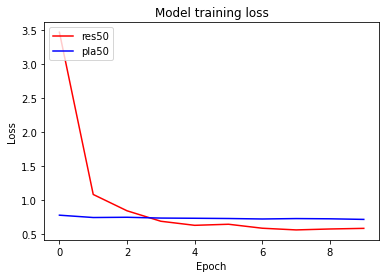

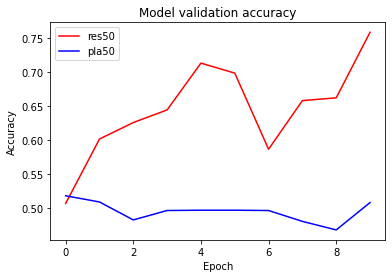

In [42]:
plot_loss_graph(res_history_50, pla_history_50, 50)
plot_acc_graph(res_history_50, pla_history_50, 50)